In [1]:
from os.path import exists, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import nan_euclidean_distances

# from settings import classes_species
from viz_utils import *

wd = join('..', '..', 'data')

# Similarity Measures for Fish Welfare Criteria
### Initial Hypotheses
Certain pairs of criteria will have a higher potential of being jointly met, be that because farms that meet this criteria, generally also meet the other criteria, or because criteria are inter-related somehow. For example, we might imagine stress and aggression to be positively correlated as we expect stress to exacerbate aggression, and we might expect home range and aggression to be correlated as fish in confined spaces may become more aggressive.

* [_An ordinal attribute is an attribute whose possible values have a meaningful order or ranking among them, but the magnitude between successive values is not known._](https://www.raynergobran.com/2016/02/distance-observations-numeric-ordinal/)
* [Distance for ordinal measures](https://people.revoledu.com/kardi/tutorial/Similarity/OrdinalVariables.html)
* [Previous work from bootcamp](https://www.overleaf.com/project/60d210fc6e835b84704f2b57)

### Criteria (explanations to be added later)
| Id | Criterion      | Description |
| --- | ----------- | ----------- |
| 17 | Home range      |        |
| 18 | Depth range   |         |
| 29 | Migration   |         |
| 30 | Reproduction   |         |
| 31 | Aggregation   |         |
| 32 | Aggression   |         |
| 33 | Substrate   |         |
| 34 | Stress   |         |
| 35 | Malformation   |         |
| 36 | Slaughter   |         |

### Data description
10 different criteria, 55 fish ids. Likelihood is binary and Potential has three categories.


### Questions
* What similarity measure is suitable for sparse, ordinal data, with additional certainty scores?

#### Measures to try
* Spearman
* Kendall tau
* Euclidean distance
* nan-Euclidean distance
* Hamming distance
* nan-Hamming distance
* Cosine similarity: not meaningful for sparse data
* Resampling

## Load and initial look at data

In [2]:
subsetting = False
df = pd.read_csv(join(wd, 'feb_farm_data_s2.csv'))

if subsetting:
    actinopterygii = classes_species['Actinopterygii']
    df_temp = df[['Fish', 'Name']].dropna()
    fish_ids = {int(key): value for key, value in zip(df_temp['Fish'], df_temp['Name'])}
    fish_ids_r = {value: key for key, value in fish_ids.items()}
    actinopterygii_ids = [fish_ids_r[fish] for fish in actinopterygii]
    df = df[df['Fish ID'].isin(actinopterygii_ids)]

# get criterion dictionary
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}
criteria_dict_r = {value: key for key, value in criteria_dict.items()}

# set up dataframe for each of likelihood, potential, and uncertainty
likelihood = df.pivot(index="Fish ID", columns="Criterion", values="Likelihood")
potential = df.pivot(index="Fish ID", columns="Criterion", values="Potential")
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# combine into one multiindex df (useful for operations later)
df_all = make_multilevel(likelihood, potential)

# remove all fish for which there are no findings
# valid = certainty[(certainty >= 0).all(axis=1)].index
# likelihood = likelihood.loc[valid, :]
# potential = potential.loc[valid, :]
# certainty = certainty.loc[valid, :]

likelihood.to_csv(join(wd, 'likelihood.csv'))
potential.to_csv(join(wd, 'potential.csv'))
certainty.to_csv(join(wd, 'certainty.csv'))

In [3]:
# Check unique values (<0 should be removed)
print(set(likelihood.values.ravel()))
print(set(potential.values.ravel()))

{0, 2, -1, -2}
{0, 1, 2, -2, -1}


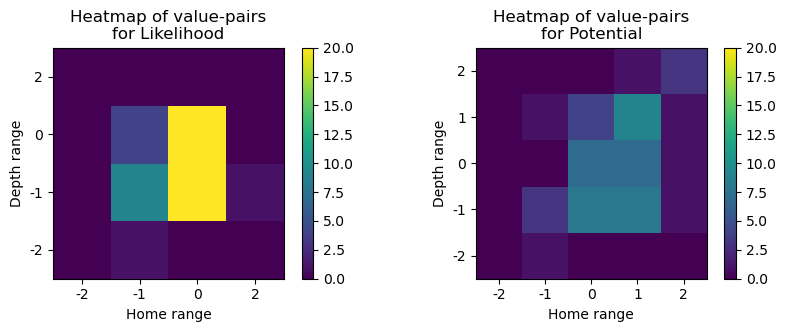

In [4]:
# inspect a single pair of criteria for Potential and Likelihood
i = 'Home range'
j = 'Depth range'

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

plot_heatmap(likelihood, i, j, [-2, -1, 0, 2], axs[0], 'Likelihood')
plot_heatmap(potential, i, j, [-2, -1, 0, 1, 2], axs[1], 'Potential')

In [5]:
# make a multilevel dataframe and remove negative values
idx = pd.IndexSlice
both = make_multilevel(likelihood, potential)
both = both.applymap(lambda x: np.nan if x < 0 else x)
likelihood = both.loc[:, idx[:, 'likelihood']].droplevel('level', axis=1)
potential = both.loc[:, idx[:, 'potential']].droplevel('level', axis=1)

# get normalised rank transformations (to use with quantitative distance measures such as Euclidean)
likelihood_z = (likelihood / 2) / (2 - 1)
potential_z = (potential) / (3 - 1)

In [6]:
both.head()

Criterion         17                   18                   29            \
level     likelihood potential likelihood potential likelihood potential   
Fish ID                                                                    
1                NaN       1.0        NaN       2.0        NaN       1.0   
2                NaN       1.0        0.0       0.0        0.0       1.0   
3                NaN       NaN        0.0       0.0        0.0       0.0   
4                NaN       NaN        0.0       0.0        0.0       0.0   
5                NaN       NaN        0.0       0.0        0.0       0.0   

Criterion         30                   31                   32            \
level     likelihood potential likelihood potential likelihood potential   
Fish ID                                                                    
1                0.0       1.0        NaN       NaN        0.0       1.0   
2                0.0       1.0        NaN       1.0        NaN       1.0   
3                0.0       1.0        NaN       NaN        NaN       1.0   
4                0.0       1.0        NaN       NaN        NaN       1.0   
5                0.0       0.0        NaN       NaN        NaN       NaN   

Criterion         33                   34                   35            \
level     likelihood potential likelihood potential likelihood potential   
Fish ID                                                                    
1                0.0       1.0        0.0       1.0        0.0       1.0   
2                0.0       1.0        0.0       1.0        0.0       2.0   
3                0.0       2.0        0.0       1.0        NaN       1.0   
4                NaN       1.0        NaN       1.0        NaN       NaN   
5                0.0       1.0        NaN       NaN        0.0       1.0   

Criterion         36            
level     likelihood potential  
Fish ID                         
1                2.0       2.0  
2                0.0       2.0  
3                NaN       2.0  
4                NaN       2.0  
5                NaN       2.0

In [7]:
# look at data now, all negatives are replaces by NaNs
likelihood.head()

Criterion,17,18,29,30,31,32,33,34,35,36
Fish ID,,,,,,,,,,
1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2.0
2,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
4,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN


In [8]:
# look at what unique values exist in dataframe
print(set(pd.unique(likelihood.values.ravel('K'))))
print(set(pd.unique(potential.values.ravel('K'))))

{0.0, 2.0, nan}
{0.0, 1.0, 2.0, nan}


In [9]:
# look at what unique values exist in dataframe
print(set(pd.unique(likelihood_z.values.ravel('K'))))
print(set(pd.unique(potential_z.values.ravel('K'))))

{0.0, 1.0, nan}
{0.5, 0.0, 1.0, nan}


# Measures in one dimension
## Euclidean Distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^n \left(u_i - v_i \right)^2} $$

## nan-Euclidean Distance
$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\frac{T}{P} \sum_{i=1}^n \left(u_i - v_i \right)^2} $$

In [10]:
i = 'Home range'
j = 'Depth range'
col1 = criteria_dict_r[i]
col2 = criteria_dict_r[j]

m = "Substrate"
n = "Slaughter"
col3 = criteria_dict_r[m]
col4 = criteria_dict_r[n]

In [11]:
# look at example results
def euclidean_dist(df, col1, col2):
    """Requires normalised data."""
    return np.sqrt(((df[col1] - df[col2]) ** 2).sum(skipna=True))

def nan_euclidean_dist(df, col1, col2):
    """Requires normalised data."""
    T = len(df)
    P = T - len(df[[col1, col2]].dropna())
    
    return np.sqrt((T / P) * ((df[col1] - df[col2]) ** 2).sum(skipna=True))

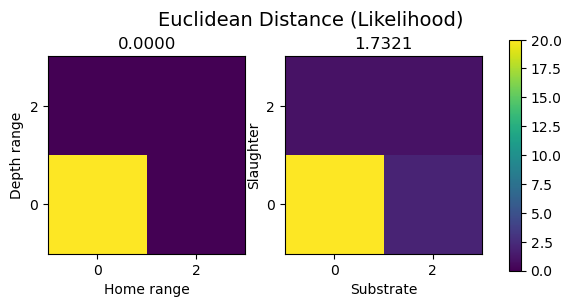

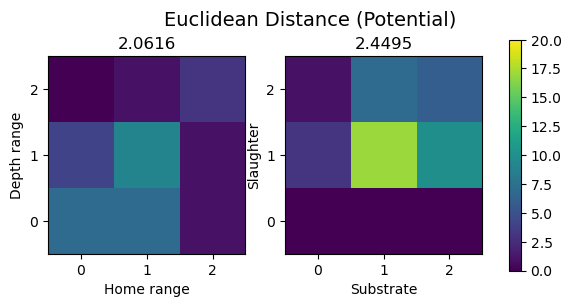

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{euclidean_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{euclidean_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Euclidean Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{euclidean_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{euclidean_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Euclidean Distance (Potential)", fontsize=14);

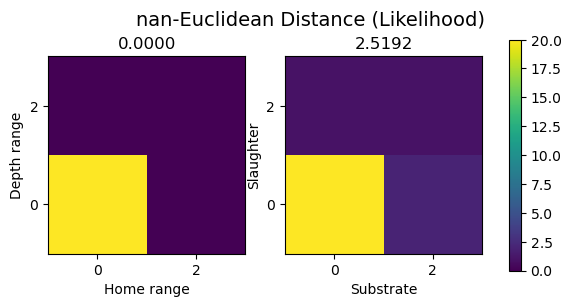

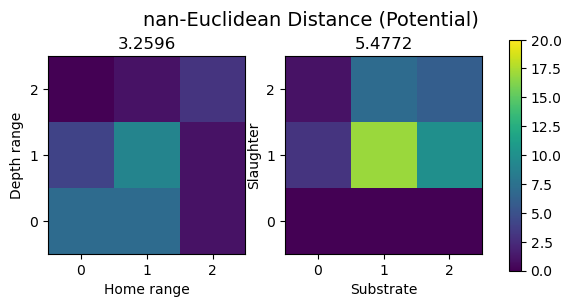

In [13]:
# look at example results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nan_euclidean_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{nan_euclidean_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Euclidean Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nan_euclidean_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{nan_euclidean_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Euclidean Distance (Potential)", fontsize=14);

## Hamming distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^n |u_i - v_i |} $$


## nan-Hamming distance

$$ d(\mathbf{u}, \mathbf{v}) = \sqrt{ \frac{T}{P} \sum_{i=1}^n |u_i - v_i |} $$

In [14]:
# look at example results
def hamming_dist(df, col1, col2):
    """Requires normalised data."""
    return np.sqrt(np.abs(df[col1] - df[col2]).sum(skipna=True))

def nanhamming_dist(df, col1, col2):
    """Requires normalised data."""
    T = len(df)
    P = T - len(df[[col1, col2]].dropna())
    
    return np.sqrt((T / P) * np.abs(df[col1] - df[col2]).sum(skipna=True))

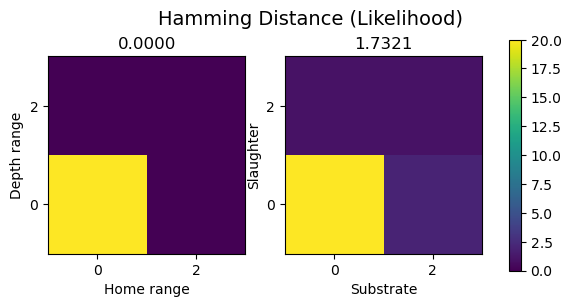

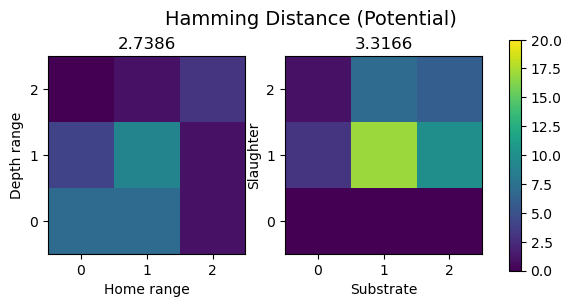

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{hamming_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{hamming_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Hamming Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{hamming_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{hamming_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Hamming Distance (Potential)", fontsize=14);

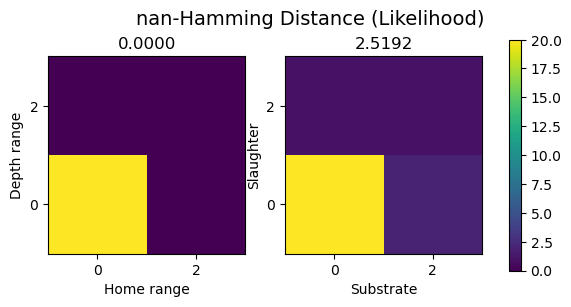

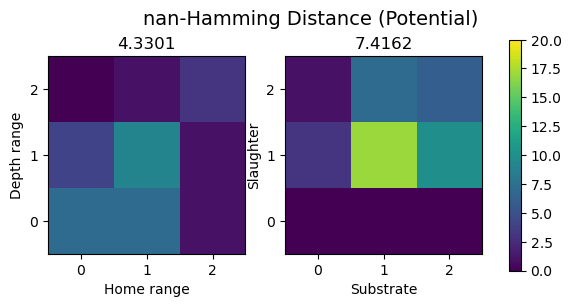

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nanhamming_dist(likelihood_z, col1, col2):.4f}");
axs[1].set_title(f"{nanhamming_dist(likelihood_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Hamming Distance (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{nanhamming_dist(potential_z, col1, col2):.4f}");
axs[1].set_title(f"{nanhamming_dist(potential_z, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("nan-Hamming Distance (Potential)", fontsize=14);

## Cosine Similarity

$$ S_c(\mathbf{u}, \mathbf{v}) = \cos(\theta) = \frac{\mathbf{u} \cdot \mathbf{v}}{||\mathbf{u}||\cdot||\mathbf{v}||} = \frac{\sum_i^n u_iv_i}{\sqrt{\sum_i^n u_i^2}\sqrt{\sum_i^n v_i^2}} $$

Can't calculate cosine similarity for zero vector. Returning NaN.



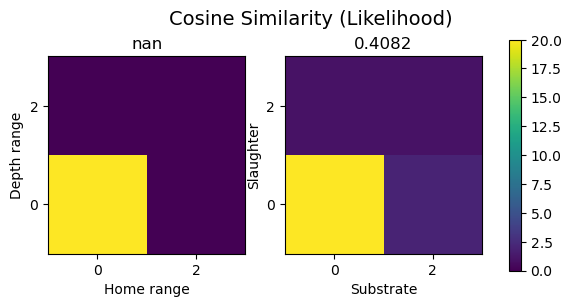

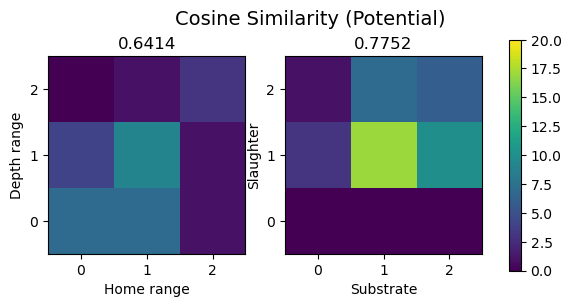

In [17]:
def cosine_similarity(df, col1, col2):
    """Requires normalised data"""
    if (df[col1].sum() == 0) or (df[col2].sum() == 0):
        print("Can't calculate cosine similarity for zero vector. Returning NaN.\n")
        return np.nan
    return (df[col1] * df[col2]).sum() / ( np.sqrt((df[col1] ** 2).sum()) * np.sqrt((df[col2] ** 2).sum()))


# look at example results
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(likelihood, i, j, [0, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(likelihood, m, n, [0, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{cosine_similarity(likelihood, col1, col2):.4f}");
axs[1].set_title(f"{cosine_similarity(likelihood, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Cosine Similarity (Likelihood)", fontsize=14);


fig, axs = plt.subplots(1, 2, figsize=(7, 3))
im = plot_heatmap(potential, i, j, [0, 1, 2], axs[0], 'Likelihood', cbar=False)
plot_heatmap(potential, m, n, [0, 1, 2], axs[1], 'Likelihood', cbar=False)
axs[0].set_title(f"{cosine_similarity(potential, col1, col2):.4f}");
axs[1].set_title(f"{cosine_similarity(potential, col3, col4):.4f}");
fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Cosine Similarity (Potential)", fontsize=14);

## Plots

In [18]:
global N, thresh
N = len(likelihood)
thresh = 15  # if less than 10 values present the return nan

# look at how many empty values per column
print('Likelihood')
print(N - likelihood.isnull().sum(axis=0))
print('\nPotential')
print(N - potential.isnull().sum(axis=0))

Likelihood
Criterion
17    24
18    41
29    40
30    50
31    19
32    24
33    44
34    42
35    28
36    36
dtype: int64

Potential
Criterion
17    34
18    50
29    48
30    51
31    32
32    36
33    53
34    46
35    35
36    46
dtype: int64


In [19]:
def cosine_similarity(col1, col2):
    P = len(col1)
    if P < thresh:
        return np.nan
    
    if (col1.sum() == 0) or (col2.sum() == 0):
        return np.nan
    
    return (col1 * col2).sum() / ( np.sqrt((col1 ** 2).sum()) * np.sqrt((col2 ** 2).sum()))

def euclidean_similarity(col1, col2):
    """Requires normalised data. Not bounded. Return NaN if less than thresh values present."""
    # count number present/missing
    P = len(col1)
    if P < thresh:
        return np.nan
    
    euclidean_dist = np.sqrt(((col1 - col2) ** 2).sum())
    return 1 / (1 + euclidean_dist)

def naneuclidean_similarity(col1, col2):
    """Requires normalised data. Not bounded."""
    # count number present/missing
    P = len(col1)
    if P < thresh:
        return np.nan
    
    # get metric
    euclidean_dist = np.sqrt((N / P) * ((col1 - col2) ** 2).sum())
    return 1 / (1 + euclidean_dist)

def hamming_similarity(col1, col2):
    """Requires normalised data?"""
    P = len(col1)
    if P < thresh:
        return np.nan
    hamming_dist = np.sqrt(np.abs(col1 - col2).sum())
    return 1 / (1 + hamming_dist)

In [23]:
# col1, col2 = likelihood[34], likelihood[31]


# #     intersection = len(list(set(col1).intersection(col2)))
# #     union = (len(list1) + len(list2)) - intersection
# #     return float(intersection) / union


# col1.intersection(col2)

In [24]:
# col1, col2 = potential[34], potential[31]

# def pairwise_complete(col1, col2):
#     ind1 = col1.dropna().index
#     ind2 = col2.dropna().index
#     ind = list(set(ind1) & set(ind2))
#     ind.sort()
#     ind = pd.core.indexes.numeric.Int64Index(ind)
#     return ind


# # def custom_spearman(col1, col2, weights, nan=True):
# # col1.rank

# # pairwise complete observations
# ind = pairwise_complete(col1, col2)
# col1 = col1[ind]
# col2 = col2[ind]

# # get the ranks and sort col2's ranks according to col1
# col1_ranks = col1.rank()
# col2_ranks = col2.rank()
# col1_rankorder = col1_ranks.sort_values().index
# col1_ranked = col1_ranks[col1_rankorder]
# col2_ranked = col2_ranks[col1_rankorder]

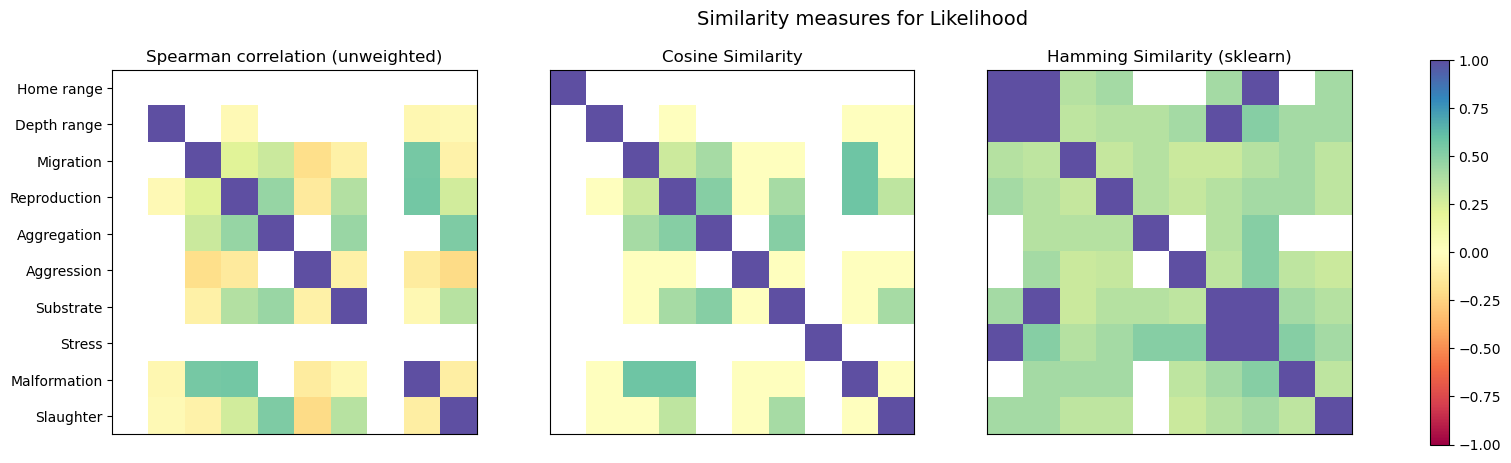

In [31]:
# plot correlation coefficients
spearman_likelihood = likelihood.corr(method='spearman')
cosine_likelihood = likelihood.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_z.corr(method=euclidean_similarity)
# naneuclidean_likelihood = 1 / (1 + nan_euclidean_distances(likelihood.transpose(), likelihood.transpose()))
naneuclidean_likelihood = likelihood_z.corr(method=naneuclidean_similarity)
hamming_likelihood = likelihood_z.corr(method=hamming_similarity)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

ax = axs[0]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation (unweighted)')
ax.set_xticks([])
ax.set_yticks([*range(10)])
ax.set_yticklabels([*criteria_dict.values()], rotation=0)
# plt.colorbar(im, ax=ax);


ax = axs[1]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[2]
im = ax.imshow(hamming_likelihood, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Hamming Similarity (sklearn)')
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar(im, ax=ax);

fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Similarity measures for Likelihood", fontsize=14);

fig.savefig(join('..', 'images', 'likelihood.png'))

Pairs of criteria where less than 15 (thresh) value-pairs are present are not considered and returned as NaN. For Pearson and Cosine similarity, if either vector is the zero vector then the measure is undefined and this is also returned as NaN. Euclidean and Hamming similarity are similar, as expected. Nan-Euclidean similarity slighty reduces the similarity predicted where there are less samples present, which is good as we don't want to give equal weight when a lot of data is missing. However, in the case where both sets are all zero, unsure if it is accurate to give this a correlation of one.


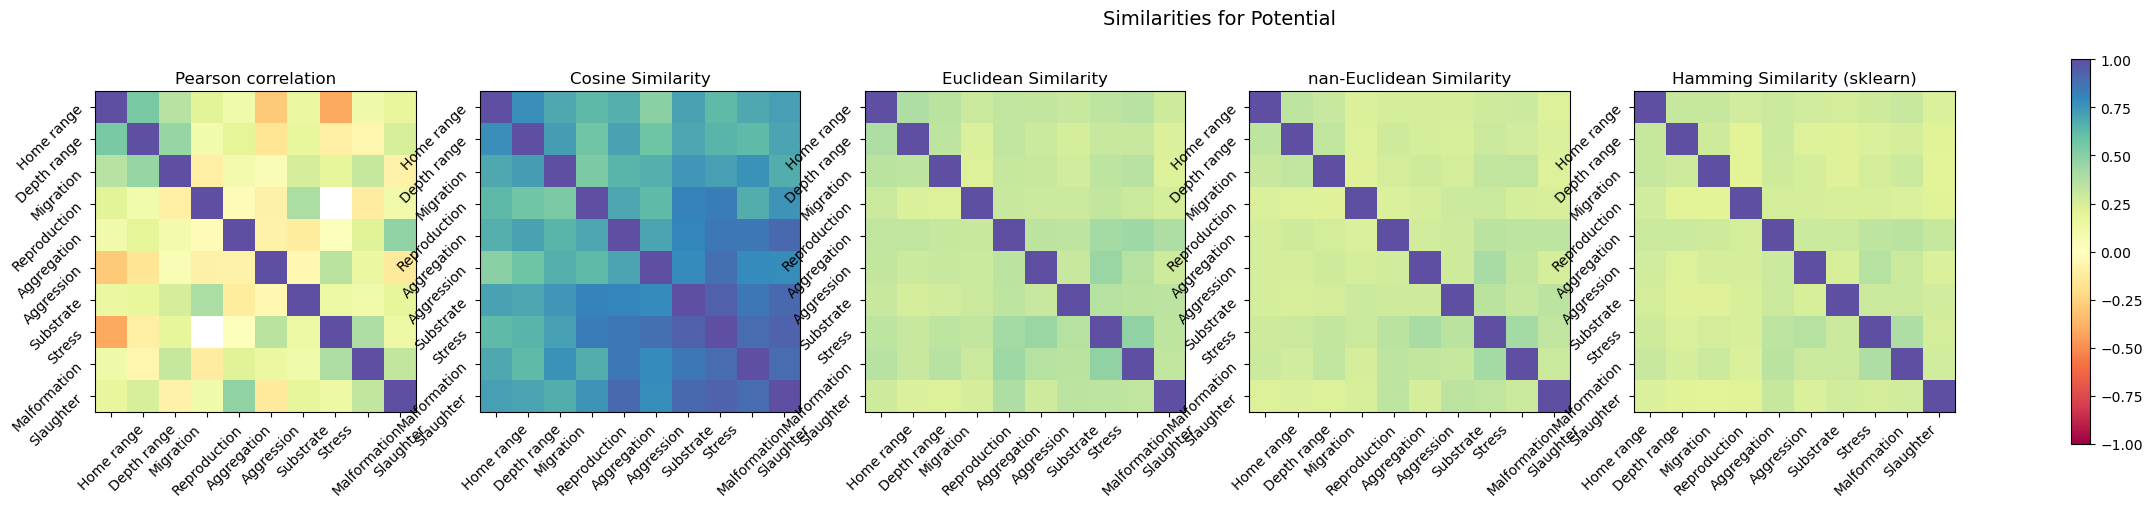

In [40]:
# plot correlation coefficients
pearson_potential = potential.corr(method='pearson')
cosine_potential = potential.corr(method=cosine_similarity)
euclidean_potential = potential_z.corr(method=euclidean_similarity)
# naneuclidean_potential = 1 / (1 + nan_euclidean_distances(potential.transpose(), potential.transpose()))
naneuclidean_potential = potential_z.corr(method=naneuclidean_similarity)
hamming_potential = potential_z.corr(method=hamming_similarity)
potentials = [pearson_potential, euclidean_potential, hamming_potential]

fig, axs = plt.subplots(1, 5, figsize=(30, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);


ax = axs[1]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(naneuclidean_potential, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('nan-Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

ax = axs[4]
im = ax.imshow(hamming_potential, cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Hamming Similarity (sklearn)')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45, ha='right')
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
# plt.colorbar(im, ax=ax);

fig.colorbar(im, ax=axs.ravel().tolist())
plt.suptitle("Similarities for Potential", fontsize=14);

fig.savefig(join('..', 'images', 'potential.png'))

In [78]:
# closer look at a few examples
comparisons = {}
high_pairs = [(17, 18), (31, 34), (34, 35)]
low_pairs = [(29, 30)]
not_agreeing = [(30, 34), (18, 29)]
pairs = high_pairs + low_pairs + not_agreeing
potentials = [pearson_potential, euclidean_potential, hamming_potential]

for p0, p1 in pairs:
    comparisons[(criteria_dict[p0], criteria_dict[p1])] = []
        
for p0, p1 in pairs:
    for potent in potentials:
        comparisons[(criteria_dict[p0], criteria_dict[p1])].append(potent.loc[p0, p1])
        
comp_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['Pearson', 'Euclidean', 'Hamming'])

In [79]:
comp_df

,Pearson,Euclidean,Hamming
"(Home range, Depth range)",0.540000,0.387426,0.309017
"(Aggregation, Stress)",0.018506,0.414214,0.333333
"(Stress, Malformation)",0.386772,0.472136,0.387426
"(Migration, Reproduction)",-0.098318,0.233715,0.207992
"(Reproduction, Stress)",NaN,0.314520,0.244966
"(Depth range, Migration)",0.459222,0.333333,0.274292


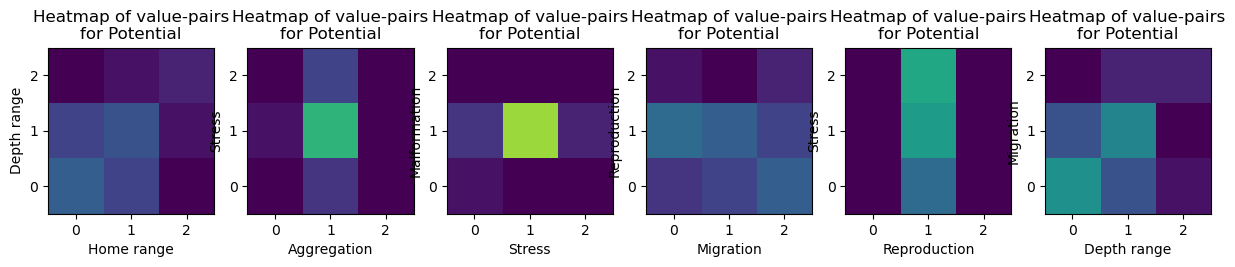

In [87]:
fig, axs = plt.subplots(1, len(pairs), figsize=(15, 8))

for i, pair in enumerate(pairs):
    p0, p1 = pair[0], pair[1]
    n0, n1 = criteria_dict[p0], criteria_dict[p1]
    im = plot_heatmap(potential, n0, n1, [0, 1, 2], axs[i], 'Potential', cbar=False)
im = plot_heatmap(potential, n0, n1, [0, 1, 2], axs[i], 'Potential', cbar=False)


## Bootstrapping data

In [281]:
def get_unique_values(df, dropna=True):
    """Helper function."""
    unique_values = pd.unique(sample.to_numpy().ravel())
    if dropna:
        mask = np.isnan(unique_values)
        unique_values = unique_values[~mask]
        
    return [*unique_values]

In [282]:
values = get_unique_values(likelihood)
print(values)

[0.0, 2.0]


In [292]:
print(N)
B = 20
n = 10

values = get_unique_values(likelihood)
print(values)

sample_phighs = []
sample_plows = []

# bootstrap resampling
for b in range(B):

    sample = likelihood.sample(n=n, replace=True)
    phighs = sample.eq(2).sum() / n
    plows = sample.eq(0).sum() / n
    
    sample_phighs.append(phighs)
    sample_plows.append(plows)

# calculate mean of statistic for each criterion
phighs = pd.DataFrame(sample_phighs, columns=[*criteria_dict.keys()]).mean()
plows = pd.DataFrame(sample_plows, columns=[*criteria_dict.keys()]).mean()

55
[0.0, 2.0]


In [294]:
plows

17    0.425
18    0.735
29    0.710
30    0.850
31    0.225
32    0.340
33    0.745
34    0.715
35    0.485
36    0.625
dtype: float64

In [293]:
phighs

17    0.000
18    0.010
29    0.055
30    0.055
31    0.060
32    0.080
33    0.045
34    0.000
35    0.005
36    0.075
dtype: float64

In [286]:
sample.eq(2).sum() / n

Criterion
17    0.0
18    0.0
29    0.2
30    0.1
31    0.3
32    0.0
33    0.0
34    0.0
35    0.1
36    0.1
dtype: float64

In [260]:
sample.unique

AttributeError: 'DataFrame' object has no attribute 'unique'

In [280]:
get_unique_values(sample)

[0.0, 2.0]

In [257]:
sample.eq(2)

Criterion,17,18,29,30,31,32,33,34,35,36
Fish ID,,,,,,,,,,
2,False,False,False,False,False,False,False,False,False,False
18,False,False,False,False,False,False,False,False,False,False
45,False,False,False,False,True,False,False,False,False,False
51,False,False,True,False,True,False,False,False,False,False
23,False,False,False,False,False,False,False,False,False,False
17,False,False,False,False,False,False,False,False,False,True
40,False,False,False,False,True,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
31,False,False,True,True,False,False,False,False,True,False


In [253]:
stds

17    0.000000
18    0.156286
29    0.489880
30    0.410776
31    0.915911
32    0.365756
33    0.255943
34    0.000000
35    0.040825
36    0.551651
dtype: float64

# Sampling data (no longer doing)
Cannot be resampling data as criteria cannot be assumed independent.
**Certainty values:** -2 (no findings), 0 (low), 1 (medium), 2 (high). <br>
**Idea:** Re-sample data according to certainty values.
$$ \mathbb{P}_{\text{high}}(\{a, b, c \} | a) = \{0.99, 0.05, 0.05\} $$
$$ \mathbb{P}_{\text{med}}(\{a, b, c \}| a) = \{0.90, 0.5, 0.5\} $$
$$ \mathbb{P}_{\text{low}}(\{a, b, c \}| a) = \{0.5, 0.25, 0.25\} $$

In [169]:
certainty_probs = {0: 0.99, 
                   1: 0.9,
                   2: 0.5}

def probabilities(score, possible_scores, certainty):
    high = certainty_probs[certainty]
    low = (1 - high) / (len(possible_scores) - 1)
    probabilities = [high if pscore==score else low for pscore in possible_scores]
    return probabilities

def random_sample(measure, certainty):
    pass

potential_sample = {}
likelihood_sample = {}

In [170]:
n = 10  # number of samples for each data point

# resample potential
for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 1, 2]  # potential
    scores = [(score, cert) for score, cert in zip(potential[criterion], certainty[criterion])]
    for score, cert in scores:
        if not np.isnan(score):
            probabilities(score, [0, 1, 2], cert)
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probabilities(score, [0, 1, 2], cert)))
        else:
            sample = np.append(sample, [np.nan] * n)

    potential_sample[criterion] = sample

potential_sample_df = pd.DataFrame.from_dict(potential_sample)
potential_sample_df_z = (potential_sample_df) / (3 - 1)

# resample likelihood
for criterion in [*criteria_dict.keys()]:
    sample = np.array([])
    possible_scores = [0, 2]  # likelihood
    scores = [(score, cert) for score, cert in zip(likelihood[criterion], certainty[criterion])]
    for score, cert in scores:
        if not np.isnan(score):
            probs = probabilities(score, possible_scores, cert)
            sample = np.append(sample, np.random.choice(possible_scores, n, p=probs))
        else:
            sample = np.append(sample, [np.nan] * n)

    likelihood_sample[criterion] = sample
    
likelihood_sample_df = pd.DataFrame.from_dict(likelihood_sample)
likelihood_sample_df_z = (likelihood_sample_df) / (2 - 1)

In [178]:
criteria_dict_r

{'Home range': 17,
 'Depth range': 18,
 'Migration': 29,
 'Reproduction': 30,
 'Aggregation': 31,
 'Aggression': 32,
 'Substrate': 33,
 'Stress': 34,
 'Malformation': 35,
 'Slaughter': 36}

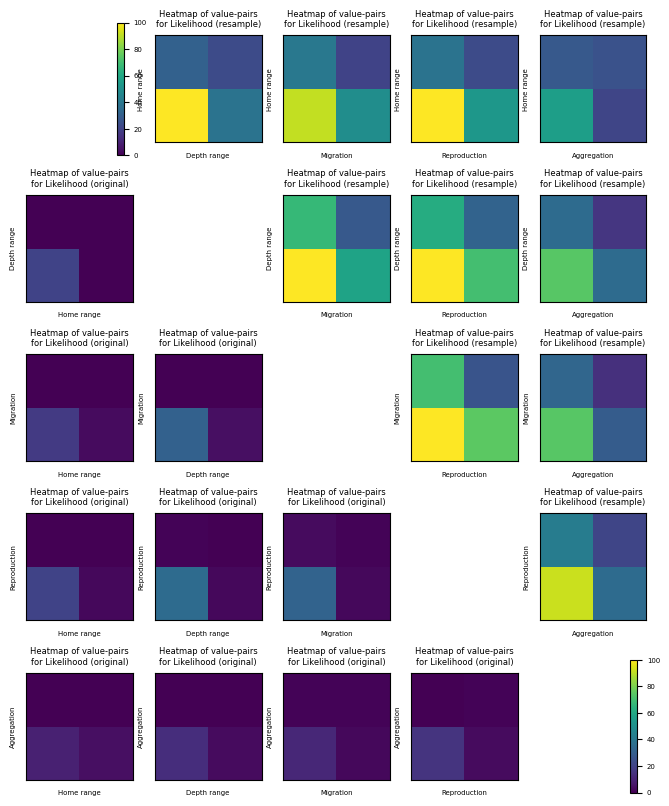

In [228]:
plt.rcParams.update({'font.size': 5})

fig, axs = plt.subplots(5, 5, figsize=(8, 10))

for i in range(5):
    for j in range(i):
        ax = axs[j, i]
        ix = [*criteria_dict.keys()][i]
        jx = [*criteria_dict.keys()][j]
        #print(f"{(ix, jx)}:")

        xlabel = [*criteria_dict.values()][i]
        ylabel = [*criteria_dict.values()][j]

        im = plot_heatmap(likelihood_sample_df, xlabel, ylabel, [0, 2], ax, 'Likelihood (resample)', lims=[0, 100], cbar=False)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

fig.colorbar(im, ax=axs[0, 0], aspect=20)


for i in range(5):
        fig.delaxes(axs[i][i])
        
        
for j in range(5):
    for i in range(j):
        ax = axs[j, i]
        ix = [*criteria_dict.keys()][i]
        jx = [*criteria_dict.keys()][j]

        xlabel = [*criteria_dict.values()][i]
        ylabel = [*criteria_dict.values()][j]

        im = plot_heatmap(likelihood, xlabel, ylabel, [0, 2], ax, 'Likelihood (original)', lims=[0, 100],
                     cbar=False, cmap='viridis')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
fig.colorbar(im, ax=axs[4, 4], aspect=20)

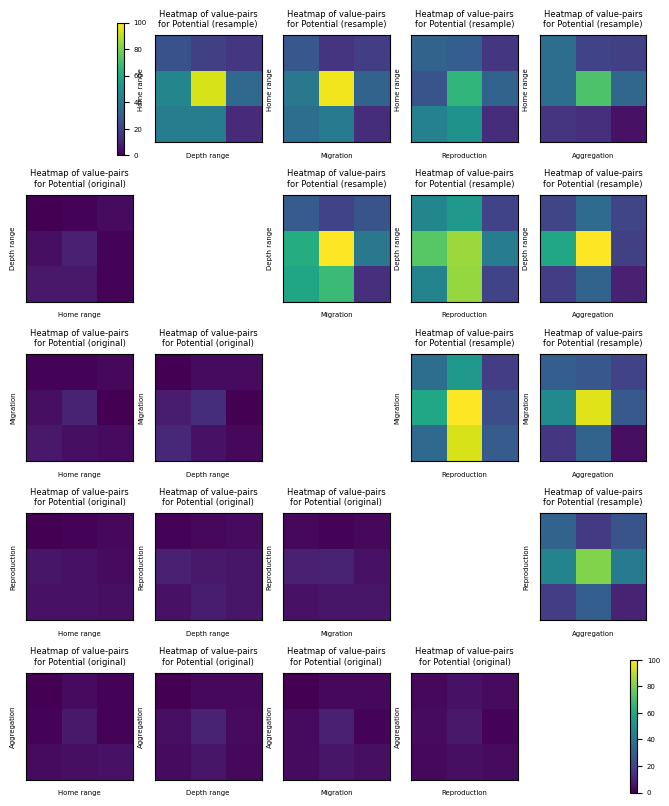

In [229]:
plt.rcParams.update({'font.size': 5})

fig, axs = plt.subplots(5, 5, figsize=(8, 10))

for i in range(5):
    for j in range(i):
        ax = axs[j, i]
        ix = [*criteria_dict.keys()][i]
        jx = [*criteria_dict.keys()][j]
        #print(f"{(ix, jx)}:")

        xlabel = [*criteria_dict.values()][i]
        ylabel = [*criteria_dict.values()][j]

        im = plot_heatmap(potential_sample_df, xlabel, ylabel, [0, 1, 2], ax, 'Potential (resample)', lims=[0, 100], cbar=False)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

fig.colorbar(im, ax=axs[0, 0], aspect=20)


for i in range(5):
        fig.delaxes(axs[i][i])
        
        
for j in range(5):
    for i in range(j):
        ax = axs[j, i]
        ix = [*criteria_dict.keys()][i]
        jx = [*criteria_dict.keys()][j]

        xlabel = [*criteria_dict.values()][i]
        ylabel = [*criteria_dict.values()][j]

        im = plot_heatmap(potential, xlabel, ylabel, [0, 1, 2], ax, 'Potential (original)', lims=[0, 100],
                     cbar=False, cmap='viridis')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
fig.colorbar(im, ax=axs[4, 4], aspect=20);

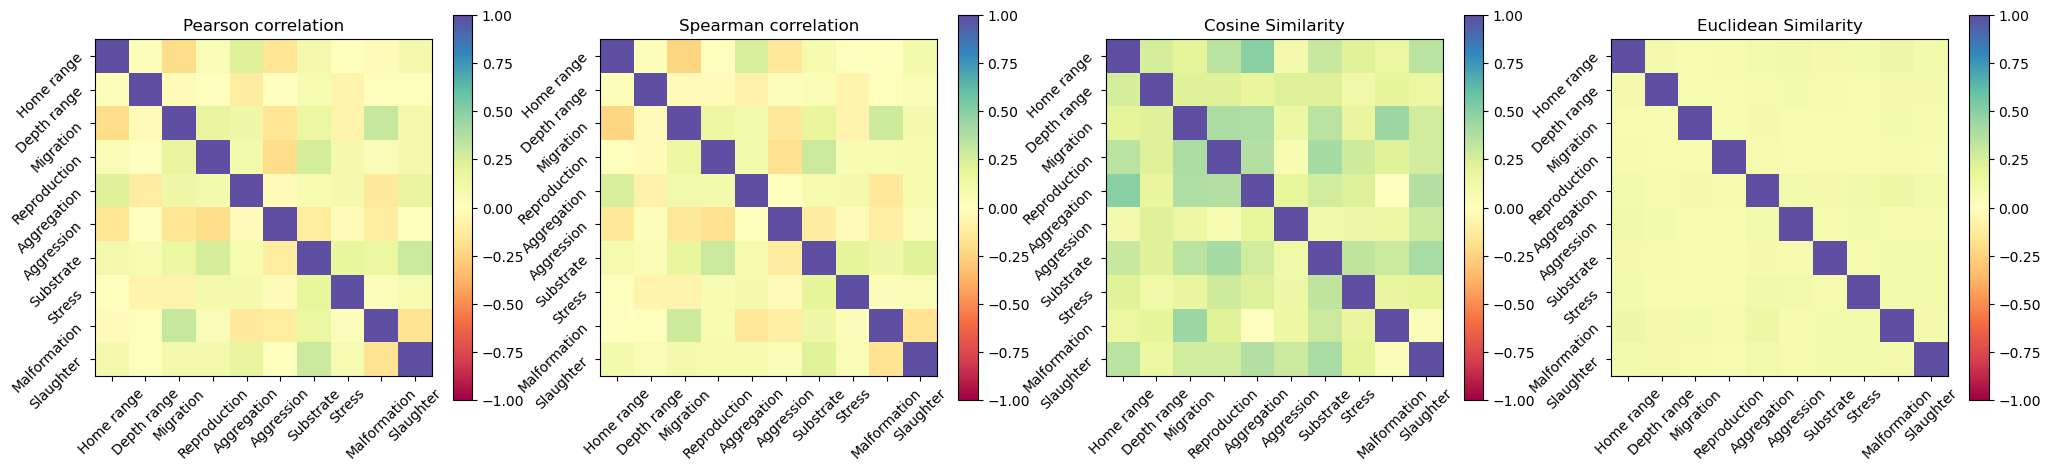

In [100]:
# plot correlation coefficients for likelihood
pearson_likelihood = likelihood_sample_df.corr(method='pearson')
spearman_likelihood = likelihood_sample_df.corr(method='spearman')
cosine_likelihood = likelihood_sample_df.corr(method=cosine_similarity)
euclidean_likelihood = likelihood_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_likelihood.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);


fig.savefig(join('..', 'images', 'likelihood_resample.png'))

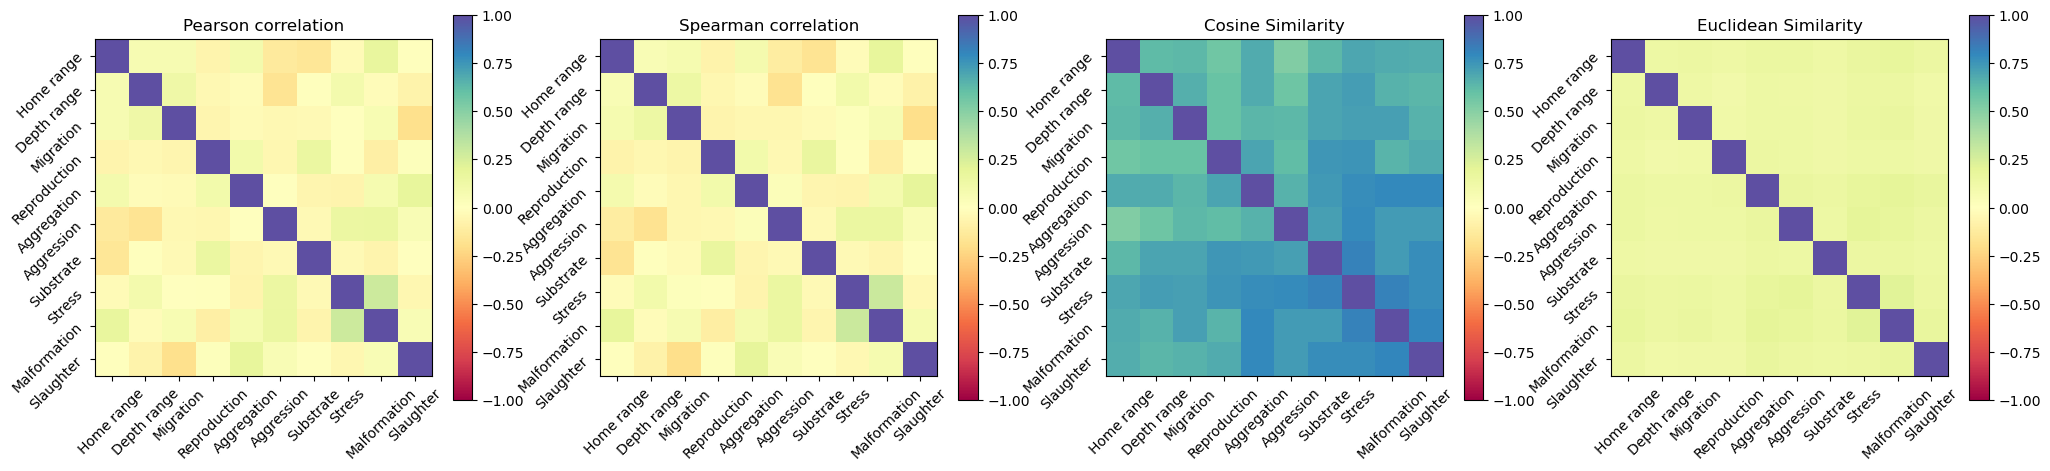

In [101]:
# plot correlation coefficients for potential
pearson_potential = potential_sample_df.corr(method='pearson')
spearman_potential = potential_sample_df.corr(method='spearman')
cosine_potential = potential_sample_df.corr(method=cosine_similarity)
euclidean_potential = potential_sample_df_z.corr(method=euclidean_similarity)

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

ax = axs[0]
im = ax.imshow(pearson_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Pearson correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[1]
im = ax.imshow(spearman_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Spearman correlation')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[2]
im = ax.imshow(cosine_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

ax = axs[3]
im = ax.imshow(euclidean_potential.to_numpy(), cmap='Spectral', vmin=-1, vmax=1)
ax.set_title('Euclidean Similarity')
ax.set_xticks([*range(10)])
ax.set_yticks([*range(10)])
ax.set_xticklabels([*criteria_dict.values()], rotation=45)
ax.set_yticklabels([*criteria_dict.values()], rotation=45)
plt.colorbar(im, ax=ax);

fig.savefig(join('..', 'images', 'potential_resample.png'))

(array([ 8., 20., 18., 22.,  8., 14.,  0.,  0.,  0., 10.]),
 array([0.5621985 , 0.60597865, 0.6497588 , 0.69353895, 0.7373191 ,
        0.78109925, 0.8248794 , 0.86865955, 0.9124397 , 0.95621985,
        1.        ]),
 <BarContainer object of 10 artists>)

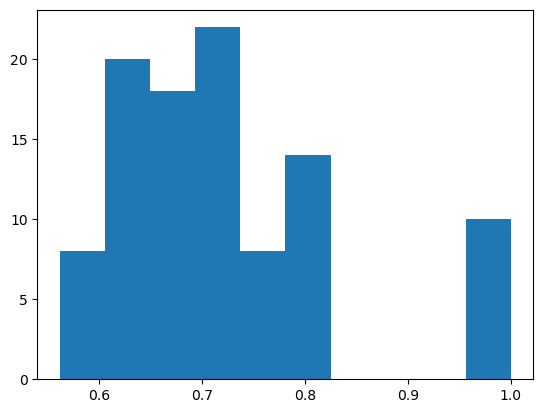

In [73]:
plt.hist(cosine_potential.to_numpy().ravel())

In [60]:
euclidean_potential

,17,18,29,30,31,32,33,34,35,36
17,1.000000,0.035211,0.033162,0.034325,0.038111,0.041933,0.032961,0.042294,0.044899,0.035133
18,0.035211,1.000000,0.030661,0.026891,0.036038,0.034850,0.028267,0.035762,0.036135,0.028833
29,0.033162,0.030661,1.000000,0.027397,0.035893,0.034267,0.030879,0.037398,0.040389,0.030178
30,0.034325,0.026891,0.027397,1.000000,0.034398,0.034563,0.027792,0.034552,0.034195,0.028647
31,0.038111,0.036038,0.035893,0.034398,1.000000,0.042443,0.035400,0.045917,0.052747,0.043948
32,0.041933,0.034850,0.034267,0.034563,0.042443,1.000000,0.033585,0.050637,0.043859,0.037063
33,0.032961,0.028267,0.030879,0.027792,0.035400,0.033585,1.000000,0.036007,0.037701,0.033590
34,0.042294,0.035762,0.037398,0.034552,0.045917,0.050637,0.036007,1.000000,0.051842,0.037778
35,0.044899,0.036135,0.040389,0.034195,0.052747,0.043859,0.037701,0.051842,1.000000,0.043532
36,0.035133,0.028833,0.030178,0.028647,0.043948,0.037063,0.033590,0.037778,0.043532,1.000000
